In [1]:
#adapted from:
#https://towardsdatascience.com/anomaly-detection-with-time-series-forecasting-c34c6d04b24a

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly.plotly as py
from matplotlib import pyplot
import plotly.graph_objs as go

import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
# import plotly.plotly as py
# import plotly.tools as tls

from matplotlib import style

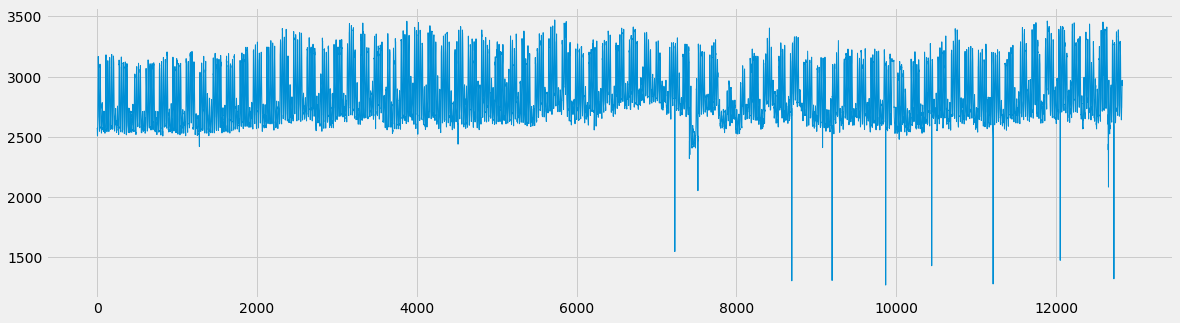

In [2]:
#read the data in to a dataframe (conver this later to use pipulling)
time_series_df = pd.read_csv("GBSF_Electricity_Demand_kBtu.csv")
time_series_df = time_series_df.dropna()

# Dan's filtering to get test and train data
style.use('fivethirtyeight')
df_clean = time_series_df.loc[:,'GBSF_Electricity_Demand_kBtu'][0:int(len(time_series_df.GBSF_Electricity_Demand_kBtu)/2)]
df_clean = df_clean.drop(df_clean[df_clean.values < 2400].index, axis=0)
df_merge = pd.concat([df_clean, time_series_df.loc[:,'GBSF_Electricity_Demand_kBtu'][int(len(time_series_df.GBSF_Electricity_Demand_kBtu)/2):]], axis=0)
df_merge.sort_index(ascending=True)
df_merge.plot(figsize=(18,5), linewidth=1)

time_series_df["GBSF_Electricity_Demand_kBtu"] = df_merge

In [3]:
# time_series_df.Timestamp = pd.to_datetime(time_series_df.Timestamp, format='%Y-%m-%d %H:%M:%S')
# time_series_df = time_series_df.sort_values(by="Timestamp")
# time_series_df = time_series_df.reset_index(drop=True)
time_series_df.head()

,Timestamp,GBSF_Electricity_Demand_kBtu
0,2018-02-01 00:00:00,2567.533494
1,2018-02-01 01:00:00,2571.118335
2,2018-02-01 02:00:00,2527.213831
3,2018-02-01 03:00:00,2511.278558
4,2018-02-01 04:00:00,2506.536407


In [4]:
actual_vals = time_series_df.GBSF_Electricity_Demand_kBtu.values
actual_log = np.log10(actual_vals)
print(len(actual_vals))

12823


In [5]:
# train, test = actual_vals[0:2400], actual_vals[2400:]
# train, test = actual_vals[0:6412], actual_vals[6412:]
train, test = actual_vals[0:2400], actual_vals[6412:7412]
train_log, test_log = np.log10(train), np.log10(test)
my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 7) #change these?

In [6]:
# figsize=(12, 7)
# plt.figure(figsize=figsize)
# pyplot.plot(train_log)
# pyplot.show()
# figsize=(12, 7)
# plt.figure(figsize=figsize)
# pyplot.plot(test_log)
# pyplot.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/anaconda3/lib/python3.6/sit

Test rmse: 0.017


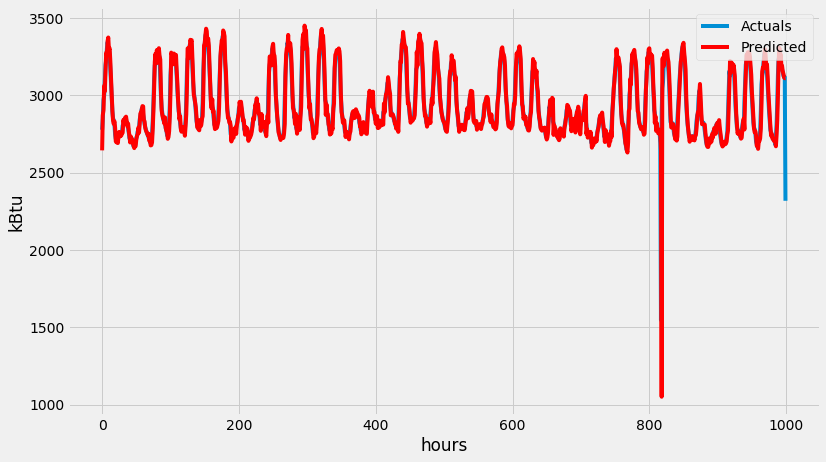

In [7]:
# This takes way too long and needs to be somehow optimazied -- either run on a GPU or use smaller train set
history = [x for x in train_log]
predictions = list()
predict_log = list()

for t in range(len(test_log)):
    model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (output[0], obs))

error = math.sqrt(mean_squared_error(test_log, predict_log))
print('Test rmse: %.3f' % error)

# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.xlabel("hours")
pyplot.ylabel("kBtu")
pyplot.show()

In [8]:
#so that previous cell doesn't need to be run becuase it takes forever
import pickle

with open('predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

with open('predict_log.pkl', 'wb') as f:
    pickle.dump(predict_log, f)    

In [9]:
from pyramid.arima import auto_arima
#consider changing the parameters
stepwise_model = auto_arima(train_log, start_p=1, start_q=1, max_p=3, max_q=3, m=7, start_P=0, seasonal=True, 
                            d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [10]:
import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error

# train, test = actual_vals[0:500], actual_vals[2400:2650]
# train_log, test_log = np.log10(train), np.log10(test)

history = [x for x in train_log]
predictions = list()
predict_log = list()

for t in range(len(test_log)):
    #run the model below to retrain
    #model = sm.tsa.SARIMAX(history, order=my_order, seasonal_order=my_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (output[0], obs))

error = math.sqrt(mean_squared_error(test_log, predict_log))
print('Test rmse: %.3f' % error)

# plot
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(test,label='Actuals')
pyplot.plot(predictions, color='red',label='Predicted')
pyplot.legend(loc='upper right')
pyplot.xlabel("hours")
pyplot.ylabel("kBtu")
pyplot.show()

NameError: name 'stepwise_model' is not defined

In [11]:
#so that previous cell doesn't need to be run becuase it takes forever
import pickle

with open('predictions2.pkl', 'wb') as f:
    pickle.dump(predictions, f)

with open('predict_log2.pkl', 'wb') as f:
    pickle.dump(predict_log, f)    

In [12]:
predicted_df = pd.DataFrame()
predicted_df['load_date'] = time_series_df['Timestamp'][6412:]
predicted_df['actuals'] = test
predicted_df['predicted'] = predictions
predicted_df.reset_index(inplace=True)

del predicted_df['index']
predicted_df.head()

ValueError: Length of values does not match length of index

In [13]:
import numpy as np
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['actuals']-df['predicted']
    df['percentage_change'] = ((df['actuals'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    df = df.sort_values(by='load_date', ascending=False)
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
return df

SyntaxError: 'return' outside function (<ipython-input-13-fbbfc8c1fe6e>, line 28)

In [14]:
def plot_anomaly(df, metric_name):

    dates = df.Timestamp

    bool_array = (abs(df['anomaly_points']) > 0)
    
    #And a subplot of the Actual Values.
    actuals = df["test"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan

#     color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "orange", 3: "red"}
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
        domain=dict(x=[0, 1], y=[0, 0.3]),
        columnwidth=[1, 2 ],
        header = dict(height = 20,
                      values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                                ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                      font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                      fill = dict(color='#d562be')),
        cells = dict(values = [df.round(3)[k].tolist() for k in ['Timestamp', 'actuals', 'predicted',
                                                                 'percentage_change','color']],
                     line = dict(color='#506784'),
                     align = ['center'] * 5,
                     font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                     suffix=[None] + [''] + [''] + ['%'] + [''],
                     height = 27,
                     fill=dict(color=[df['color'].map(color_map)],)))

    anomalies = go.Scatter(name="Anomaly",
                           x=dates,
                           xaxis='x1',
                           yaxis='y1',
                           y=df['anomaly_points'],
                           mode='markers',
                           marker = dict(color ='red',
                          size = 11,line = dict(
                                             color = "red",
                                             width = 2)))
    upper_bound = go.Scatter(hoverinfo="skip",
                             x=dates,
                             showlegend =False,
                             xaxis='x1',
                             yaxis='y1',
                             y=df['3s'],
                             marker=dict(color="#444"),
                             line=dict(
                                 color=('rgb(23, 96, 167)'),
                                 width=2,
                                 dash='dash'),
                             fillcolor='rgba(68, 68, 68, 0.3)',
                             fill='tonexty')
    lower_bound = go.Scatter(name='Confidence Interval',
                              x=dates,
                             xaxis='x1',
                             yaxis='y1',
                              y=df['-3s'],
                              marker=dict(color="#444"),
                              line=dict(
                                  color=('rgb(23, 96, 167)'),
                                  width=2,
                                  dash='dash'),
                              fillcolor='rgba(68, 68, 68, 0.3)',
                              fill='tonexty')
    Actuals = go.Scatter(name= 'Actuals',
                         x= dates,
                         y= df['actuals'],
                        xaxis='x2', yaxis='y2',
                         mode='line',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))
    Predicted = go.Scatter(name= 'Predicted',
                         x= dates,
                         y= df['predicted'],
                        xaxis='x2', yaxis='y2',
                         mode='line',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="orange"))
    # create plot for error...
    Error = go.Scatter(name="Error",
                       x=dates, y=df['error'],
                       xaxis='x1',
                       yaxis='y1',
                       mode='line',
                       marker=dict(size=12,
                                   line=dict(width=1),
                                   color="red"),
                       text="Error")
    anomalies_map = go.Scatter(name = "anomaly actual",
                                       showlegend=False,
                                       x=dates,
                                       y=anomaly_points,
                                       mode='markers',
                                       xaxis='x2',
                                       yaxis='y2',
                                        marker = dict(color ="red",
                                      size = 11,
                                     line = dict(
                                         color = "red",
                                         width = 2)))
    Mvingavrg = go.Scatter(name="Moving Average",
                               x=dates,
                               y=df['meanval'],
                               mode='line',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(size=12,
                                           line=dict(width=1),
                                           color="green"),
                               text="Moving average")
    axis=dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title= metric_name,
        margin = dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
        yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f')))

    
    fig = go.Figure(data = [table,anomalies,anomalies_map,
                            upper_bound,lower_bound,Actuals,Predicted,
                            Mvingavrg,Error], layout = layout)
    pyplot(fig)
    pyplot.show()

classify_df=detect_classify_anomalies(predicted_df, 7)
classify_df.reset_index(inplace=True)
del classify_df['index']

plot_anomaly(classify_df, "GBSF_Electricity_Demand_kBtu")

KeyError: 'actuals'